In [8]:
import os
import time
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob

#---------------------------------------

#from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

#---------------------------------------

import tensorflow as tensorflow
#from tensorflow.keras import datasets, layers, models
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#---------------------------------------

In [9]:
# Load the training and testing data

def train_data(training_path):
    classes, class_paths = zip(*[(label, os.path.join(training_path, label, image))
                                 for label in os.listdir(training_path) if os.path.isdir(os.path.join(training_path, label))
                                 for image in os.listdir(os.path.join(training_path, label))])

    training_dataframe = pd.DataFrame({'Class Path': class_paths, 'Class': classes})
    return training_dataframe


def test_data(testing_path):
    classes, class_paths = zip(*[(label, os.path.join(testing_path, label, image))
                                 for label in os.listdir(testing_path) if os.path.isdir(os.path.join(testing_path, label))
                                 for image in os.listdir(os.path.join(testing_path, label))])

    testing_dataframe = pd.DataFrame({'Class Path': class_paths, 'Class': classes})
    return testing_dataframe


training_dataframe = train_data('Training/')
training_dataframe

testing_dataframe = test_data('Testing/')
testing_dataframe



,Class Path,Class
0,Testing/glioma\Te-glTr_0000.jpg,glioma
1,Testing/glioma\Te-glTr_0001.jpg,glioma
2,Testing/glioma\Te-glTr_0002.jpg,glioma
3,Testing/glioma\Te-glTr_0003.jpg,glioma
4,Testing/glioma\Te-glTr_0004.jpg,glioma
...,...,...
1306,Testing/pituitary\Te-pi_0295.jpg,pituitary
1307,Testing/pituitary\Te-pi_0296.jpg,pituitary
1308,Testing/pituitary\Te-pi_0297.jpg,pituitary
1309,Testing/pituitary\Te-pi_0298.jpg,pituitary


## Preprocessing

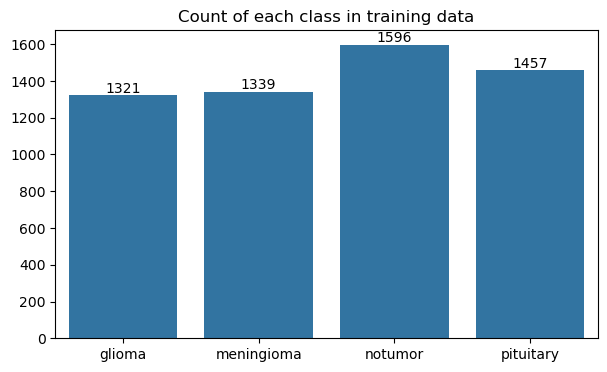

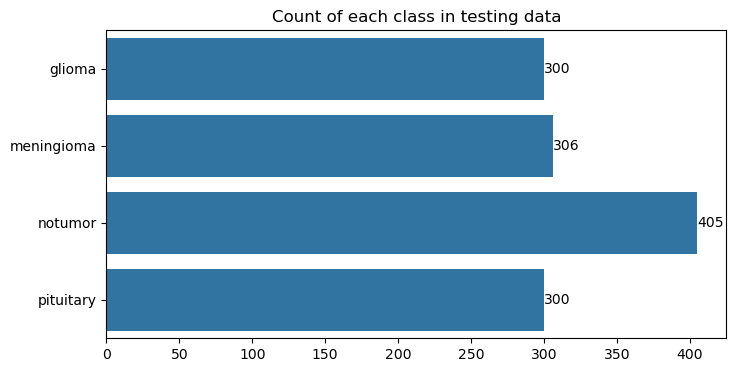

In [11]:
# Create an instance of ImageDataGenerator 
# Normalise images - rescale
data_gen = ImageDataGenerator(rescale=1./255)  # Normalizing the images

# Standardise brightness
_gen = ImageDataGenerator(rescale=1/255,
                          brightness_range=(0.8, 1.2))

# Check balance of data 
# Count of images in each class in train data
plt.figure(figsize=(7,4))
ax = sns.countplot(data=training_dataframe, x='Class')  # Ensure 'Class' is correct

ax.set(xlabel='', ylabel='', title='Count of each class in training data')

# Add bar labels if there are bars to label
if ax.containers:
    ax.bar_label(ax.containers[0])

plt.show()


# Count of images in each class in test data
plt.figure(figsize=(8, 4))
ax = sns.countplot(y=testing_dataframe['Class'])

ax.set(xlabel='', ylabel='', title='Count of each class in testing data')
ax.bar_label(ax.containers[0])

plt.show()



Found 5713 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.
{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


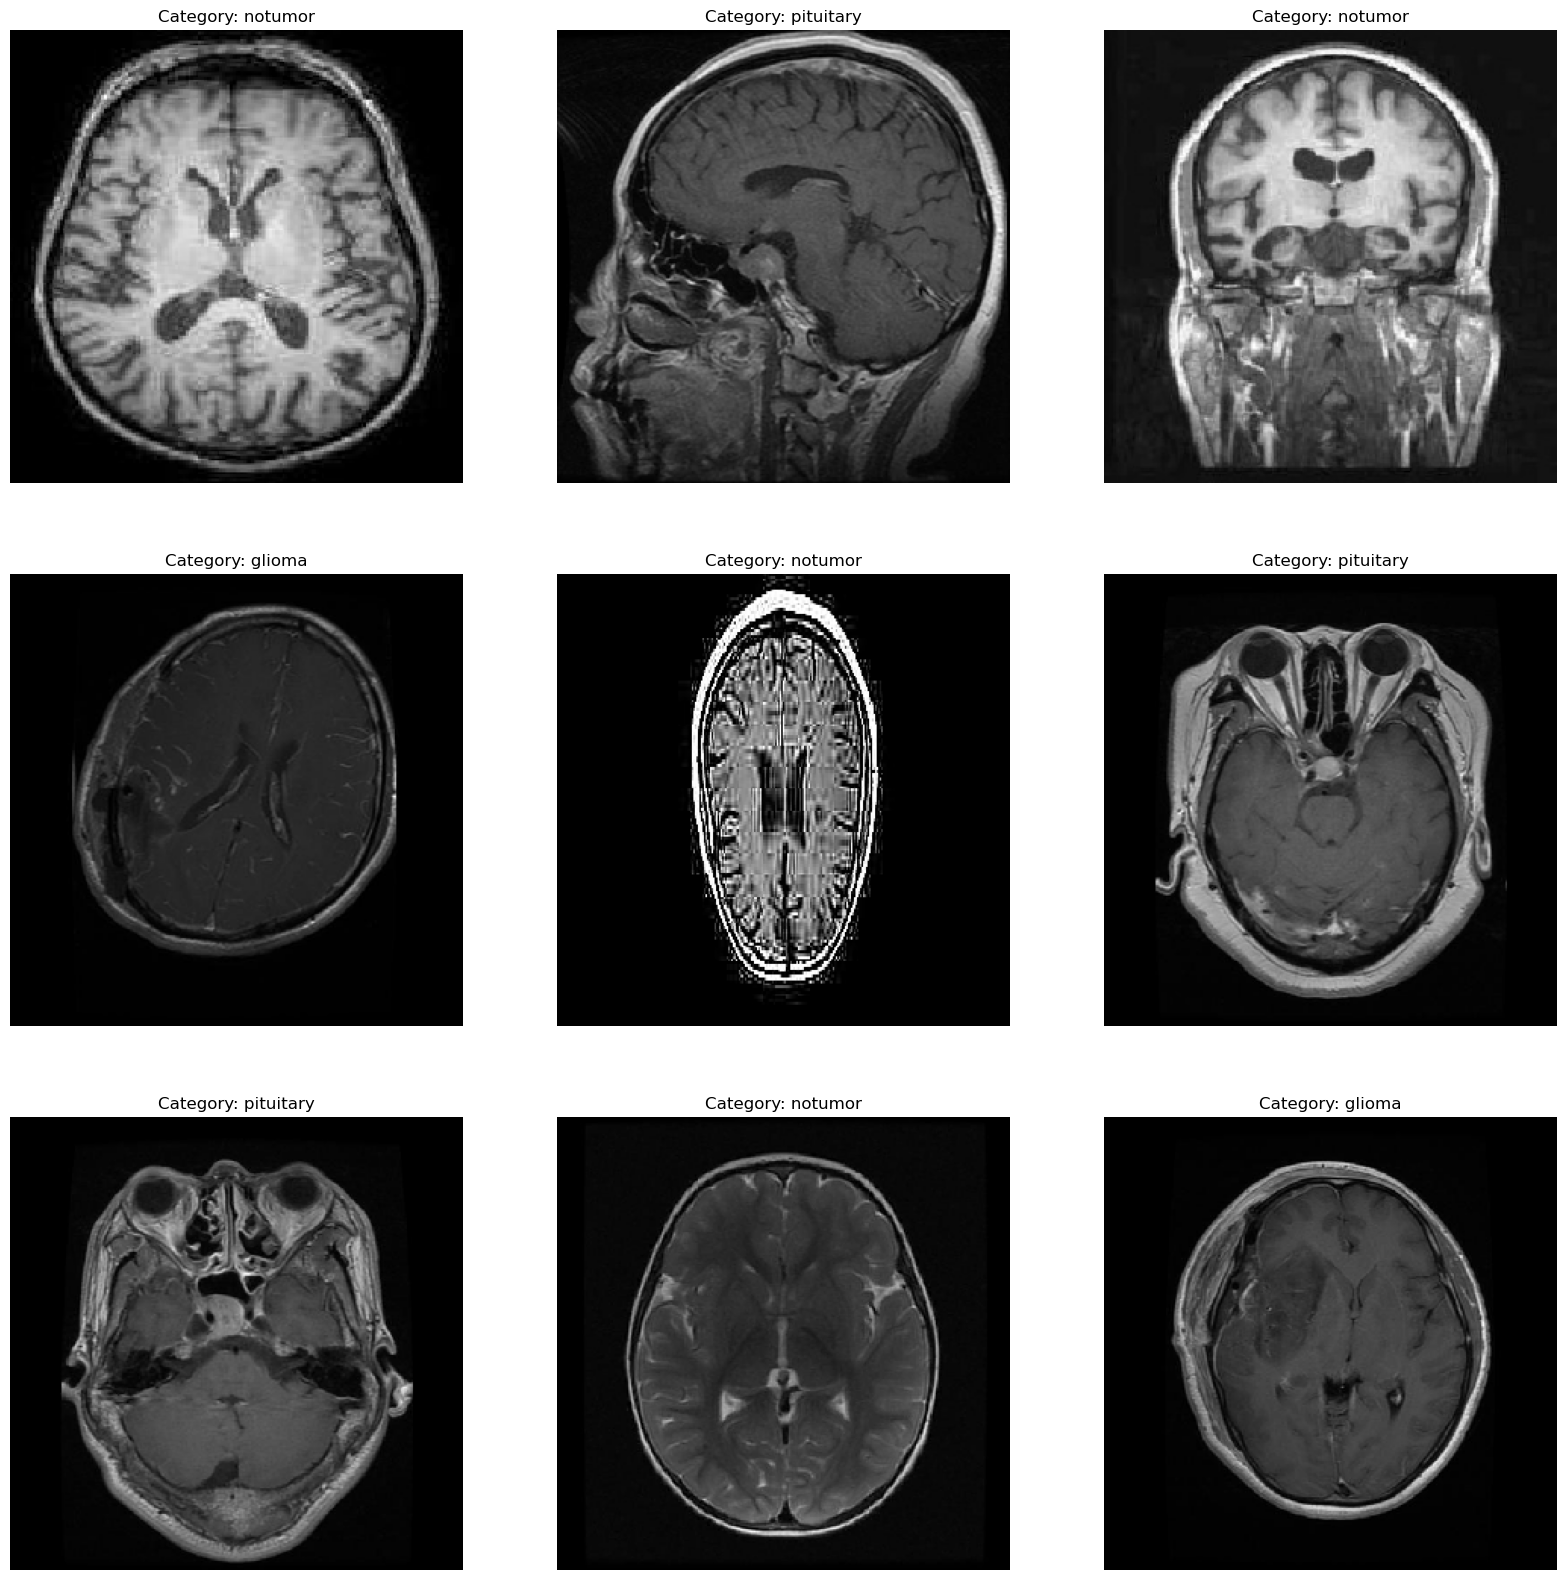

In [12]:
img_size=299,299
batch_size = 32

# Create a generator for the training data
train_gen = data_gen.flow_from_directory(
    # Path to the training data directory
    'Training/',  
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',   
    shuffle=True
)


# Create a generator for the testing data
test_gen = data_gen.flow_from_directory(
    'Testing/',  
    target_size=img_size,
    class_mode='categorical', 
    shuffle=False
)

# Get a batch of images and labels
images, labels = next(train_gen)

# view the category names 
print(train_gen.class_indices)

# Reverse class_indices to get a list of class names
class_names = list(train_gen.class_indices.keys())

# Visualize the images and their labels in one hot encoding [0, 0, 0, 0] 
plt.figure(figsize=(20, 20))
for i in range(9):  # Display 9 images
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    
      # Convert the one-hot encoded label to a category name
    category_index = labels[i].argmax()  # Gets index of the active class in one-hot encoding
    category_name = class_names[category_index]  # Maps index to class name
    plt.title(f"Category: {category_name}")
    plt.axis('off')  # Hide axis

plt.show()

In [17]:
# Assuming train_gen is already created
valid_classes = set(train_gen.class_indices.keys())

# Check if all images in training_dataframe have a valid class
invalid_entries = training_dataframe[~training_dataframe['Class'].isin(valid_classes)]

if invalid_entries.empty:
    print("All images have a valid class.")
else:
    print("Some images have an invalid class:")
    print(invalid_entries)

All images have a valid class.


In [19]:
# Establish and configure the modelH
# I went for a sequential linear model because of its simplicity and suitability for simple feedforward neural networks.
# It's ideal for models where each layer has a single input tensor and a single output tensor

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(299, 299, 3)), #pass the input shape in the first layer
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(4, activation='softmax')  # Use 'sigmoid' for binary classification
])

# compile and optimise with Adamax 
model.compile(Adamax(learning_rate= 0.001),
              loss= 'categorical_crossentropy',
              metrics= ['accuracy',
                        Precision(),
                        Recall()])


C:\Users\SENCH\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [21]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 297, 297, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 148, 148, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 146, 146, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 73, 73, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 341056)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      43,655,296 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 43,675,204 (166.61 MB)

 Trainable params: 43,675,204 (166.61 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
# visualise the model 
tensorflow.keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


## Training the model 
Time to train the model on the training data to learn different brain tumour types

In [26]:
# Training
# Train the model
# Record the start time
start_time = time.time()

history = model.fit(
    train_gen,
    validation_data=test_gen,
    epochs=5 # Adjust the number of epochs as needed
)


# Calculate and print the total training time
run_time = time.time() - start_time
print(f"Total training time: {run_time:.2f} seconds")


C:\Users\SENCH\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 341s 2s/step - accuracy: 0.6548 - loss: 1.0338 - precision: 0.7536 - recall: 0.5297 - val_accuracy: 0.8696 - val_loss: 0.3498 - val_precision: 0.8902 - val_recall: 0.8413
Epoch 2/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 306s 2s/step - accuracy: 0.9349 - loss: 0.2013 - precision: 0.9389 - recall: 0.9242 - val_accuracy: 0.9024 - val_loss: 0.2639 - val_precision: 0.9097 - val_recall: 0.8986
Epoch 3/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 307s 2s/step - accuracy: 0.9631 - loss: 0.1090 - precision: 0.9653 - recall: 0.9587 - val_accuracy: 0.9436 - val_loss: 0.1634 - val_precision: 0.9464 - val_recall: 0.9420
Epoch 4/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 326s 2s/step - accuracy: 0.9902 - loss: 0.0456 - precision: 0.9906 - recall: 0.9901 - val_accuracy: 0.9314 - val_loss: 0.2366 - val_precision: 0.9341 - val_recall: 0.9298
Epoch 5/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 364s 2s/step - accuracy: 0.9961 - loss: 0.0209 - precision: 0.9961 - recall: 0.9961 - val_accuracy: 0.9512 - val_loss: 0.

In [28]:
#access and plot specific metrics or analyze the model's training performance over time - 
history.history.keys()

dict_keys(['accuracy', 'loss', 'precision', 'recall', 'val_accuracy', 'val_loss', 'val_precision', 'val_recall'])

In [30]:
# Evaluate model training - 
train_score = model.evaluate(train_gen, verbose=1)
test_score = model.evaluate(test_gen, verbose=1)

print(f"Train Loss: {train_score[0]:.4f}")
print(f"Train Accuracy: {train_score[1]*100:.2f}%")
print('-' * 20)

print('-' * 20)
print(f"Test Loss: {test_score[0]:.4f}")
print(f"Test Accuracy: {test_score[1]*100:.2f}%")

179/179 ━━━━━━━━━━━━━━━━━━━━ 47s 262ms/step - accuracy: 0.9992 - loss: 0.0094 - precision: 0.9992 - recall: 0.9992
41/41 ━━━━━━━━━━━━━━━━━━━━ 12s 281ms/step - accuracy: 0.9272 - loss: 0.2433 - precision: 0.9272 - recall: 0.9272
Train Loss: 0.0098
Train Accuracy: 99.91%
--------------------
--------------------
Test Loss: 0.1483
Test Accuracy: 95.12%


In [32]:
predictions = model.predict(test_gen)
y_predict = np.argmax(predictions, axis=1)
y_predict

41/41 ━━━━━━━━━━━━━━━━━━━━ 11s 253ms/step


array([0, 0, 0, ..., 3, 3, 3], dtype=int64)

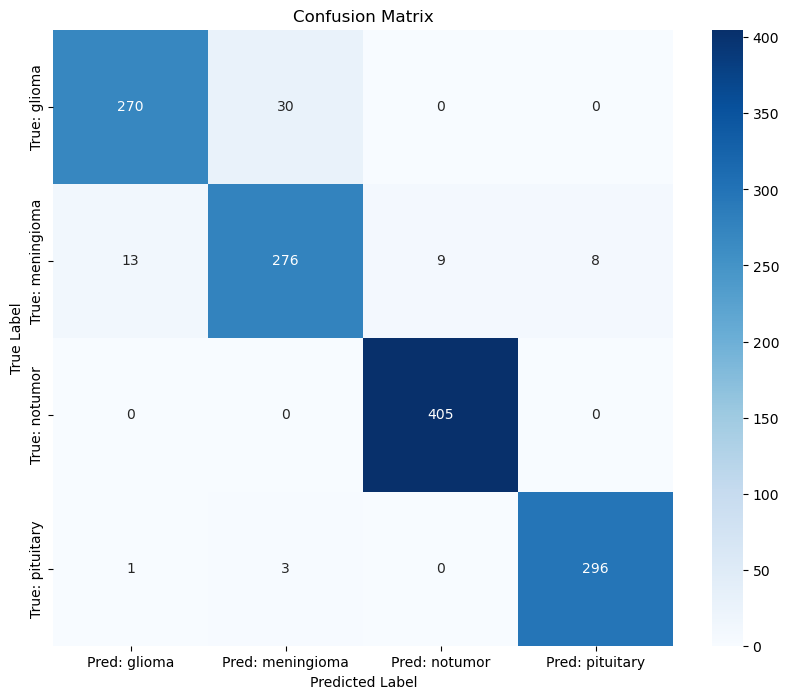

In [34]:
cmatrix = confusion_matrix(test_gen.classes, y_predict)
labels = list(class_names)
plt.figure(figsize=(10, 8))
sns.heatmap(cmatrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[f'Pred: {label}' for label in labels], 
            yticklabels=[f'True: {label}' for label in labels])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [43]:
from IPython.display import display  # Only needed in Jupyter notebooks

# Create DataFrame from misclassified data
misclassified_df = pd.DataFrame(misclassified_data)
misclassified_df.fillna("", inplace=True)  # Fill any NaN with an empty string

# Style the DataFrame
styled_df = misclassified_df.style.set_properties(**{
#    'border': '1px solid black',      # Add borders
    'padding': '5px',                 # Padding around text
    'text-align': 'center'            # Center align text
}).set_table_styles([{
    'selector': 'th',
    'props': [('font-weight', 'bold')]
}]).set_caption("Misclassified Samples")

# Display the styled table
display(styled_df)

NameError: name 'misclassified_data' is not defined

In [45]:
# Now the model is ready to be tested on inputs of unseen TEST images - it is ready to be used!
def predict(img_path):
    import numpy as np
    import matplotlib.pyplot as plt
    from keras.preprocessing.image import load_img, img_to_array
    
    # Load and preprocess the image
    img = load_img(img_path, target_size=(299, 299))  # Resize to match model input
    img_array = img_to_array(img) / 255.0  # Normalize the image
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Make predictions
    predictions = model.predict(img_array)
    probs = predictions[0]  # Get probabilities for the classes

    # Plot the results
    plt.figure(figsize=(12, 12))
    plt.subplot(2, 1, 1)
    plt.imshow(img)  # Display the original image
    
    plt.subplot(2, 1, 2)
    plt.barh(range(len(probs)), probs)  # Plot probabilities
    bars = plt.barh(class_names, probs, color='mediumpurple')
    plt.xlabel('Probability')
    plt.title('Prediction Probabilities')
    plt.show()

# Example usage:
# predict('path/to/your/unseen/mri_scan.jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step


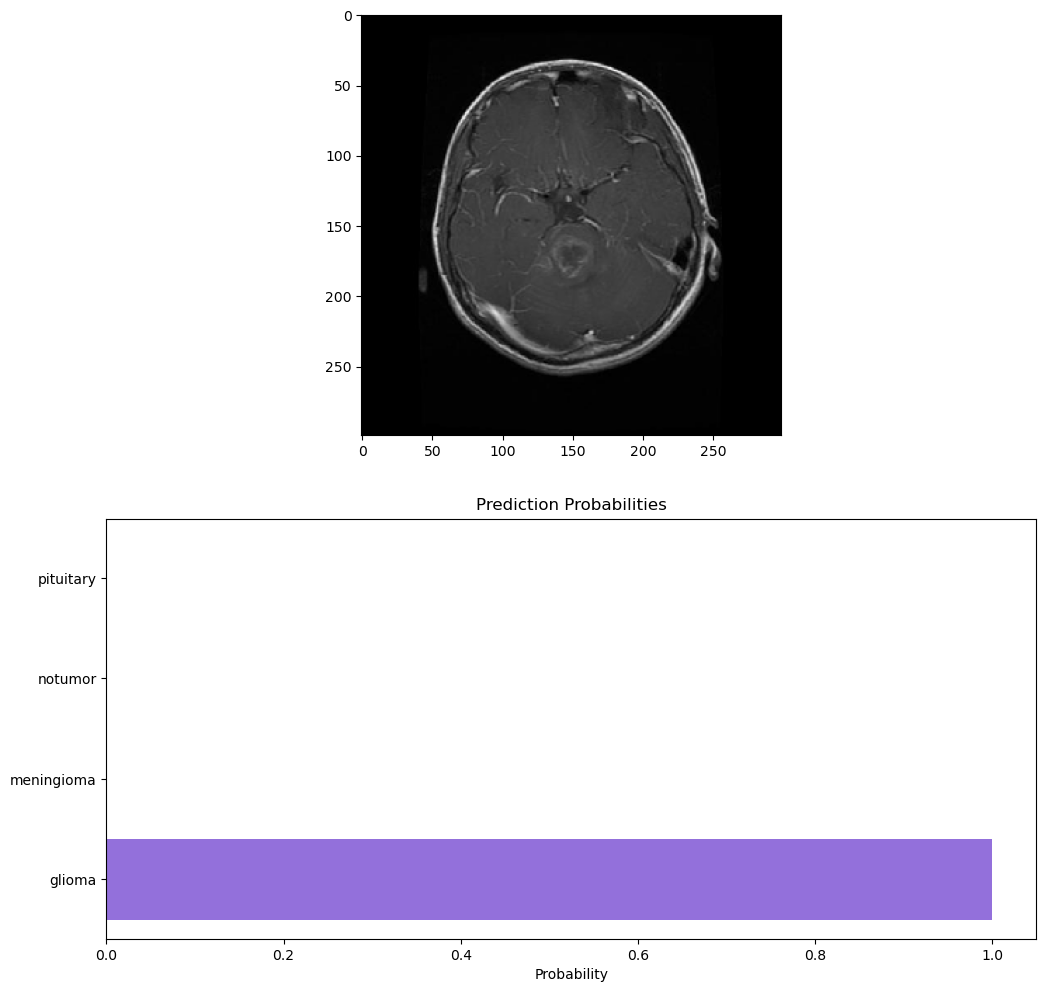

In [47]:
predict('Testing/glioma/Te-glTr_0007.jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


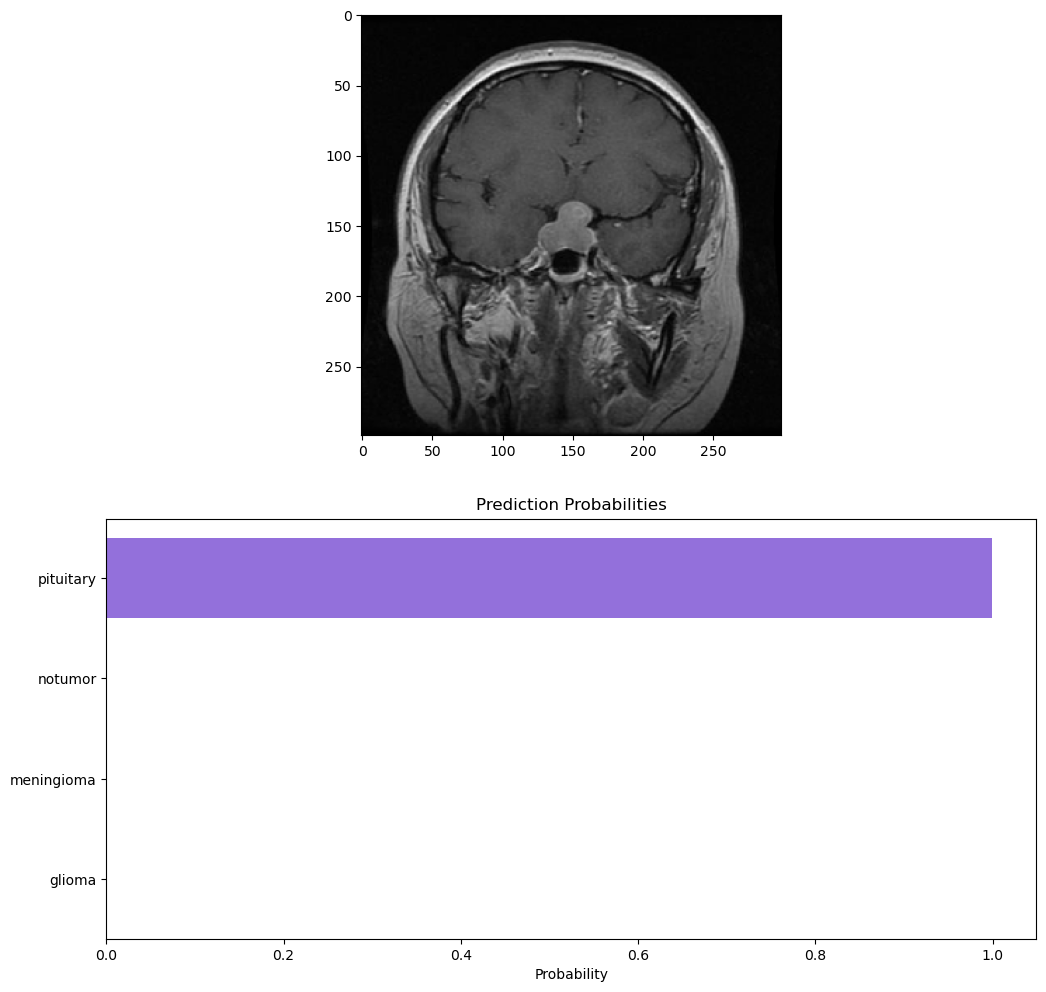

In [49]:
predict('Testing/pituitary/Te-piTr_0001.jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


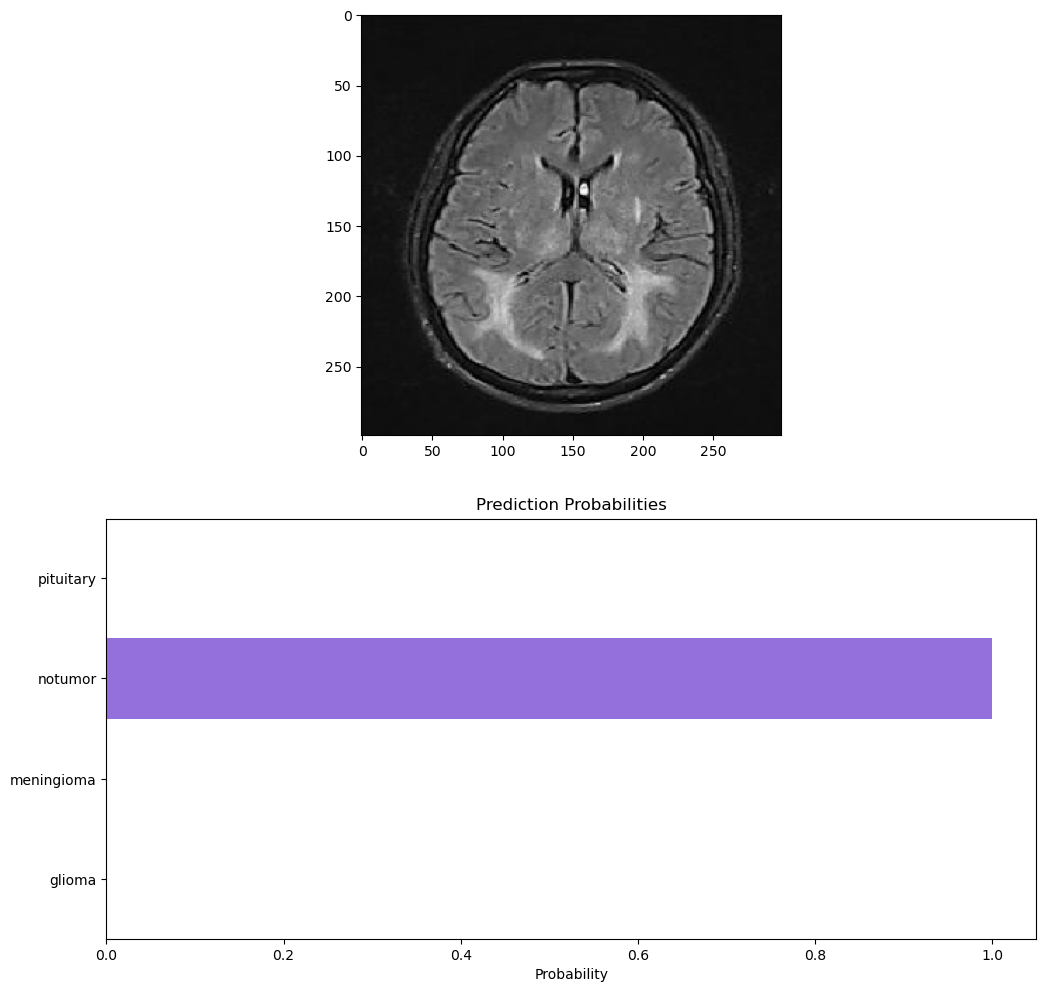

In [51]:
predict('Testing/notumor/Te-noTr_0001.jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


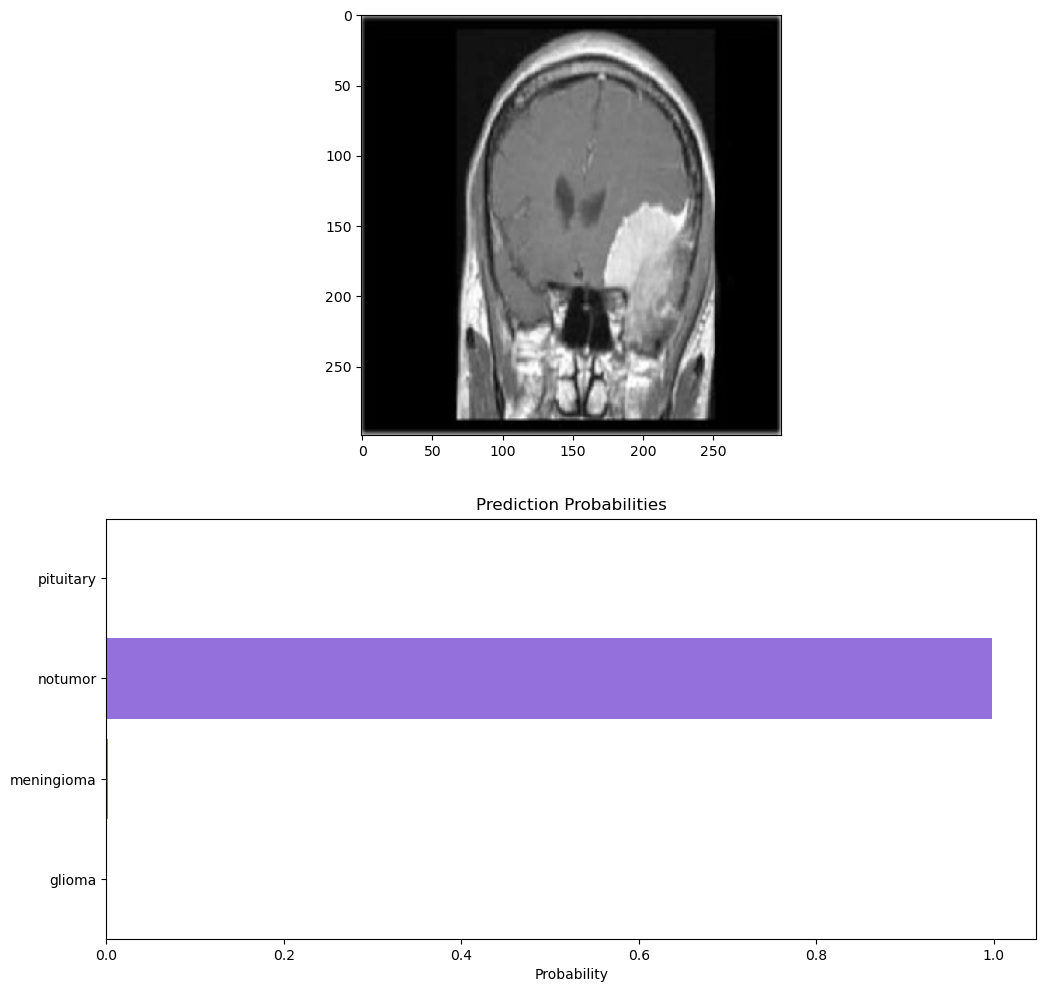

In [53]:
predict('Testing/meningioma/Te-meTr_0000.jpg')

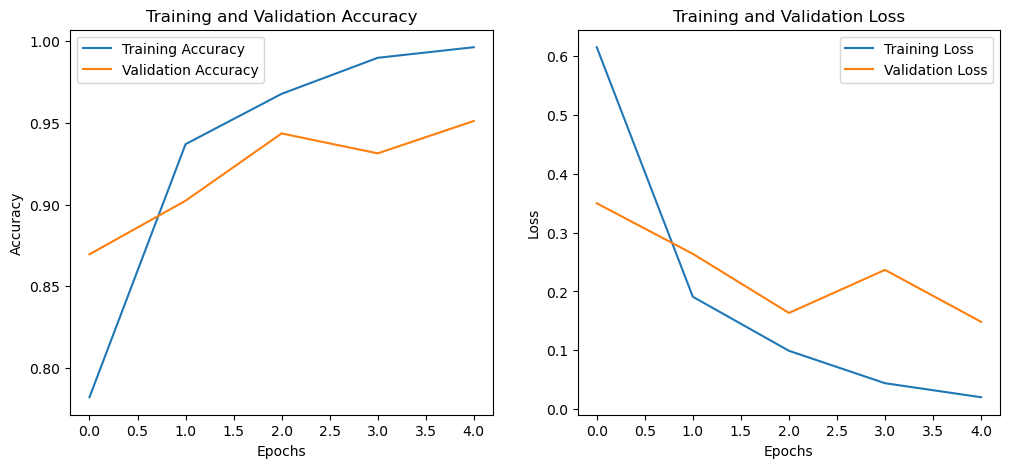

In [55]:
# Assuming 'history' is the output from model.fit()
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()